In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time

# Testing Chebyshev polynomials

# DeepONets

In [220]:
class Cheb_poly():
    def __init__(self, N, M):
        super(Cheb_poly, self).__init__()
        self.N = N
        self.M = M
        
    def make_one_function(self):
        coefficents = []
        for i in range(self.N):
            coefficents.append(np.random.uniform(-self.M,self.M))
        Cheb = np.polynomial.chebyshev.Chebyshev(coefficents,[0,1])
        return Cheb
    
    def sample_one_function(self, Cheb, x, y):
        return(Cheb(x),y,Cheb.integ(lbnd=0)(y))
    
    def sample_functions(self, n, m):
        input_u_list = []
        input_y_list = []
        output_list = []
        input_u = np.zeros((2,n,np.max(m)))
        input_y = np.zeros((2,n,1))
        output = np.zeros((2,n,1))
        #y = np.random.uniform(0, 1, 1) # Output location
        #y = np.array([1]) # Output location
        for i in range(n):
            #y = np.array([1])
            func = self.make_one_function() # Make new u(x) function
            y = np.random.uniform(0, 1, 1) # Output location
            for j in range(m.shape[0]):
                x = np.linspace(0, 1, m[j]) # Input Location
                p1, p2, p3 = self.sample_one_function(func,x, y)
                input_u[j,i,:] = np.pad(p1,(0, int(np.max(m)-m[j])))
                input_y[j,i,:] = p2
                output[j,i,:] = p3
                
        for j in range(m.shape[0]):
            input_u_list.append(input_u[j,:,0:m[j]])
            input_y_list.append(input_y[j])
            output_list.append(output[j])
            
        return input_u_list, input_y_list, output_list
    
    def sample_functions_test(self, n, m, y_dim):
        input_u_list = []
        input_y_list = []
        output_list = []
        input_u = np.zeros((2,n,np.max(m)))
        input_y = np.zeros((2, n, y_dim))
        output = np.zeros((2, n, y_dim))
        #y = np.random.uniform(0, 1, 1) # Output location
        #y = np.array([1]) # Output location
        for i in range(n):
            #y = np.array([1])
            func = self.make_one_function() # Make new u(x) function
            y = np.linspace(0, 1, y_dim) # Output location
            for j in range(m.shape[0]):
                x = np.linspace(0, 1, m[j]) # Input Location
                p1, p2, p3 = self.sample_one_function(func,x, y)
                input_u[j,i,:] = np.pad(p1,(0, int(np.max(m)-m[j])))
                input_y[j,i,:] = p2
                output[j,i,:] = p3
                
        for j in range(m.shape[0]):
            input_u_list.append(input_u[j,:,0:m[j]])
            input_y_list.append(input_y[j])
            output_list.append(output[j])
            
        return input_u_list, input_y_list, output_list
    
        #x = np.linspace(0, 1, m) # Input locations
        #y = np.linspace(0, 1, 100) # Output location
        #input_u = []
        #input_y = []
        #output = []
        #for i in range(n):
        #    p1, p2, p3 = self.one_function(x,y)
        #   input_u.append(p1)
        #    input_y.append(p2)
        #    output.append(p3)
        #return np.array(input_u), np.array(input_y), np.array(output)
    
Cheb = Cheb_poly(5, 1) # Chebyshev polynomial degree, absolute coefficent bound value i.e. [-1,1]
sensors = np.array([10, 100])
input_u, input_y, output = Cheb.sample_functions(10000, sensors) # Number of u(x) functions, Number of sensors   
input_u_test, input_y_test, output_test = Cheb.sample_functions(10000, sensors) # Number of u(x) functions, Number of sensors 

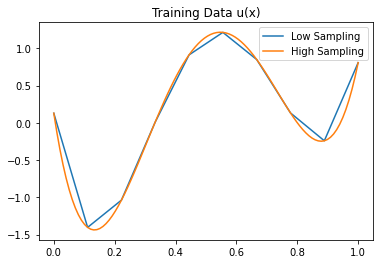

In [232]:
plt.title('Training Data u(x)')
plt.plot(np.linspace(0, 1, sensors[0]),input_u[0][1])
plt.plot(np.linspace(0, 1, sensors[1]),input_u[1][1])
plt.legend(['Low Sampling', 'High Sampling'])

In [233]:
# Base Neural Network class
class Net(nn.Module):
    def __init__(self, layers, act=nn.ReLU()):
        super(Net, self).__init__()
        self.act = act
        self.fc = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.fc.append(nn.Linear(layers[i], layers[i+1]))
    def forward(self, x):
        for i in range(len(self.fc) - 1):
            x = self.fc[i](x)
            x = self.act(x)
        x = self.fc[-1](x)
        return x

In [234]:
class bias_class(nn.Module):
    def __init__(self, input_u):
        super(bias_class, self).__init__()
        self.bias_param = nn.Parameter(torch.unsqueeze(torch.zeros(1, requires_grad=True),1))
    def forward(self):
        return self.bias_param

In [275]:
class DeepONet():
    def __init__(self, input_u, input_y, output, input_u_test, input_y_test, output_test, sensors):
        super(DeepONet,self).__init__()
        self.branch = Net([sensors,50,50])
        self.trunk = Net([1,50,50])
        self.input_u = torch.tensor(input_u, dtype = torch.float32)
        self.input_y = torch.tensor(input_y, dtype = torch.float32)
        self.output = torch.tensor(output, dtype = torch.float32)
        self.input_u_test = torch.tensor(input_u_test, dtype = torch.float32)
        self.input_y_test = torch.tensor(input_y_test, dtype = torch.float32)
        self.output_test = torch.tensor(output_test, dtype = torch.float32)
        #self.bias_param = bias_class(self.input_u)
        
        #params = list(self.branch.parameters()) + list(self.trunk.parameters()) + list(self.bias_param.parameters())
        self.params = list(self.branch.parameters()) + list(self.trunk.parameters())
        
    def get_loss(self):
        branch_out = self.branch(self.input_u)
        trunk_out = self.trunk(self.input_y)
        #pred = torch.sum(branch_out * nn.functional.relu(trunk_out), dim=-1, keepdim=True) + self.bias_param()
        pred = torch.sum(branch_out * trunk_out, dim=-1, keepdim=True)
        mse = (self.output - pred).square().mean()
        return mse
    
    def train(self, epochs):
        loss_list = []
        test_error = []

        optimizer = torch.optim.AdamW(self.params , lr=1e-3)
        for i in range(epochs):
            loss = self.get_loss()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_list.append(loss.detach().numpy())
            if i%25 == 0:
                if i%500 == 0:
                    print('Epoch: ', i)
                test_error.append(self.test())
        return np.array(loss_list), np.array(test_error)
    
    def train_lbfgs(self, lr, max_iter, max_eval, tolerance_grad, tolerance_change, history_size):
        loss_list = []
        test_error = []
        
        optimizer = torch.optim.LBFGS(self.params, lr=lr, max_iter=max_iter, max_eval=max_eval,
            tolerance_grad=tolerance_grad, tolerance_change=tolerance_change, history_size=history_size)
        def closure():
            optimizer.zero_grad()
            loss = self.get_loss()
            loss.backward(retain_graph=True)
            global iter_count 
            iter_count += 1
            loss_list.append(loss.detach().numpy())
            if iter_count%25 == 0:
                if iter_count%500 == 0:
                    print('L-BFGS iter: ', iter_count)
                    print('loss:%g'%loss.item())
                test_error.append(self.test())
            return loss
        optimizer.step(closure)
        return np.array(loss_list), np.array(test_error)
        
    def test(self):
        with torch.no_grad():
            branch_out_test = self.branch(self.input_u_test)
            trunk_out_test = self.trunk(self.input_y_test)
            #pred = torch.sum(branch_out_test * nn.functional.relu(trunk_out_test), dim=-1, keepdim=True) + self.bias_param()
            pred = torch.sum(branch_out_test * trunk_out_test, dim=-1, keepdim=True)
            mse = (self.output_test - pred).square().mean()
            
        return mse
    
    def pred(self, input_u, input_y):
        branch_out = self.branch(torch.tensor(input_u, dtype = torch.float32))
        trunk_out = self.trunk(torch.tensor(input_y, dtype = torch.float32))
        #pred = torch.sum(branch_out * nn.functional.relu(trunk_out), dim=-1, keepdim=True) + self.bias_param()
        pred = torch.sum(branch_out * trunk_out, dim=-1, keepdim=True)
        return pred

In [325]:
epochs = 500

start_time = time.time()
# Low-fidelity sampling
Test_DeepONet_low = DeepONet(input_u[0], input_y[0], output[0], input_u_test[0], input_y_test[0], output_test[0], sensors[0])
loss_list_DeepONet_low_adam, test_error_DeepONet_low_adam = Test_DeepONet_low.train(epochs)

# Optimization Hyperparameters for LBFGS
lr = 0.1; max_iter = 20000; max_eval = None; tolerance_grad = 1e-6; tolerance_change = 1e-12; history_size = 50;
global iter_count 
iter_count = 0
loss_list_DeepONet_low_lbfgs, test_error_DeepONet_low_lbfgs = Test_DeepONet_low.train_lbfgs(lr, max_iter, max_eval, tolerance_grad, tolerance_change, history_size)
elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))
iter_count_low = iter_count

Epoch:  0
L-BFGS iter:  500
loss:3.32369e-05
L-BFGS iter:  1000
loss:9.09496e-06
L-BFGS iter:  1500
loss:4.92026e-06
L-BFGS iter:  2000
loss:3.20783e-06
L-BFGS iter:  2500
loss:3.19274e-06
L-BFGS iter:  3000
loss:3.18346e-06
L-BFGS iter:  3500
loss:3.17582e-06
L-BFGS iter:  4000
loss:3.16913e-06
Training time: 85.5258


In [328]:
start_time = time.time()
# High-fidelity sampling
Test_DeepONet_high = DeepONet(input_u[1], input_y[1], output[1], input_u_test[1], input_y_test[1], output_test[1], sensors[1])
loss_list_DeepONet_high_adam, test_error_DeepONet_high_adam = Test_DeepONet_high.train(epochs)

# Optimization Hyperparameters for LBFGS
lr = 0.1; max_iter = 20000; max_eval = None; tolerance_grad = 1e-6; tolerance_change = 1e-12; history_size = 50;
global iter_count 
iter_count = 0
loss_list_DeepONet_high_lbfgs, test_error_DeepONet_high_lbfgs = Test_DeepONet_high.train_lbfgs(lr, max_iter, max_eval, tolerance_grad, tolerance_change, history_size)
elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))
iter_count_high = iter_count

Epoch:  0
L-BFGS iter:  500
loss:2.67889e-05
L-BFGS iter:  1000
loss:6.6863e-06
L-BFGS iter:  1500
loss:3.3269e-06
L-BFGS iter:  2000
loss:2.46972e-06
L-BFGS iter:  2500
loss:2.45461e-06
L-BFGS iter:  3000
loss:2.44431e-06
L-BFGS iter:  3500
loss:2.436e-06
L-BFGS iter:  4000
loss:2.42885e-06
L-BFGS iter:  4500
loss:2.42261e-06
Training time: 113.7646


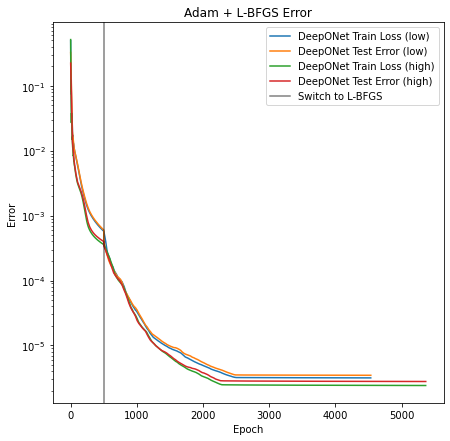

In [329]:
plt.figure(figsize=[7,7])
x = np.linspace(0,epochs,int((epochs)/25))
x_low = np.linspace(0,iter_count_low,int((iter_count_low)/25))+epochs
plt.plot(np.concatenate((loss_list_DeepONet_low_adam,loss_list_DeepONet_low_lbfgs)))
plt.plot(np.concatenate((x,x_low)),np.concatenate((test_error_DeepONet_low_adam,test_error_DeepONet_low_lbfgs)))

x_high = np.linspace(0,iter_count_high,int((iter_count_high)/25))+epochs
plt.plot(np.concatenate((loss_list_DeepONet_high_adam,loss_list_DeepONet_high_lbfgs)))
plt.plot(np.concatenate((x,x_high)),np.concatenate((test_error_DeepONet_high_adam,test_error_DeepONet_high_lbfgs)))

plt.axvline(x=epochs,c='black', linestyle='-', alpha=0.5)

plt.title('Adam + L-BFGS Error')
plt.ylabel('Error')
plt.yscale('log')
plt.xlabel('Epoch')
plt.legend(['DeepONet Train Loss (low)','DeepONet Test Error (low)','DeepONet Train Loss (high)','DeepONet Test Error (high)','Switch to L-BFGS'])
plt.show()

# Training Times

In [322]:
epochs = 500

start_time = time.time()
# Low-fidelity sampling
Test_DeepONet_low = DeepONet(input_u[0], input_y[0], output[0], input_u_test[0], input_y_test[0], output_test[0], sensors[0])
loss_list_DeepONet_low_adam, test_error_DeepONet_low_adam = Test_DeepONet_low.train(epochs)

# Optimization Hyperparameters for LBFGS
lr = 0.1; max_iter = 20000; max_eval = None; tolerance_grad = 1e-6; tolerance_change = 1e-12; history_size = 50;
global iter_count 
iter_count = 0
loss_list_DeepONet_low_lbfgs, test_error_DeepONet_low_lbfgs = Test_DeepONet_low.train_lbfgs(lr, max_iter, max_eval, tolerance_grad, tolerance_change, history_size)
elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))
iter_count_low = iter_count

Epoch:  0
L-BFGS iter:  500
loss:0.000143065
L-BFGS iter:  1000
loss:5.0798e-05
L-BFGS iter:  1500
loss:3.40187e-05
L-BFGS iter:  2000
loss:3.39134e-05
L-BFGS iter:  2500
loss:3.38816e-05
L-BFGS iter:  3000
loss:3.38574e-05
Training time: 74.9741


In [323]:
start_time = time.time()
# High-fidelity sampling
Test_DeepONet_high = DeepONet(input_u[1], input_y[1], output[1], input_u_test[1], input_y_test[1], output_test[1], sensors[1])
loss_list_DeepONet_high_adam, test_error_DeepONet_high_adam = Test_DeepONet_high.train(epochs)

# Optimization Hyperparameters for LBFGS
lr = 0.1; max_iter = 20000; max_eval = None; tolerance_grad = 1e-6; tolerance_change = 1e-12; history_size = 50;
global iter_count
iter_count = 0
loss_list_DeepONet_high_lbfgs, test_error_DeepONet_high_lbfgs = Test_DeepONet_high.train_lbfgs(lr, max_iter, max_eval, tolerance_grad, tolerance_change, history_size)
elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))
iter_count_high = iter_count

Epoch:  0
L-BFGS iter:  500
loss:2.75832e-05
L-BFGS iter:  1000
loss:7.72575e-06
L-BFGS iter:  1500
loss:4.85063e-06
L-BFGS iter:  2000
loss:4.46606e-06
L-BFGS iter:  2500
loss:4.44235e-06
L-BFGS iter:  3000
loss:4.42613e-06
L-BFGS iter:  3500
loss:4.41382e-06
L-BFGS iter:  4000
loss:4.40334e-06
L-BFGS iter:  4500
loss:4.3941e-06
Training time: 116.9178


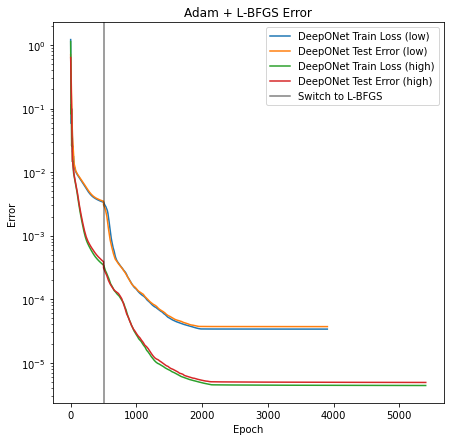

In [324]:
plt.figure(figsize=[7,7])
x = np.linspace(0,epochs,int((epochs)/25))
x_low = np.linspace(0,iter_count_low,int((iter_count_low)/25))+epochs
plt.plot(np.concatenate((loss_list_DeepONet_low_adam,loss_list_DeepONet_low_lbfgs)))
plt.plot(np.concatenate((x,x_low)),np.concatenate((test_error_DeepONet_low_adam,test_error_DeepONet_low_lbfgs)))

x_high = np.linspace(0,iter_count_high,int((iter_count_high)/25))+epochs
plt.plot(np.concatenate((loss_list_DeepONet_high_adam,loss_list_DeepONet_high_lbfgs)))
plt.plot(np.concatenate((x,x_high)),np.concatenate((test_error_DeepONet_high_adam,test_error_DeepONet_high_lbfgs)))

plt.axvline(x=epochs,c='black', linestyle='-', alpha=0.5)

plt.title('Adam + L-BFGS Error')
plt.ylabel('Error')
plt.yscale('log')
plt.xlabel('Epoch')
plt.legend(['DeepONet Train Loss (low)','DeepONet Test Error (low)','DeepONet Train Loss (high)','DeepONet Test Error (high)','Switch to L-BFGS'])
plt.show()

In [330]:
epochs = 40000

start_time = time.time()
# Low-fidelity sampling
Test_DeepONet_low = DeepONet(input_u[0], input_y[0], output[0], input_u_test[0], input_y_test[0], output_test[0], sensors[0])
loss_list_DeepONet_low_adam, test_error_DeepONet_low_adam = Test_DeepONet_low.train(epochs)              
print('Training time: %.4f' % (elapsed))

Epoch:  0
Epoch:  500
Epoch:  1000
Epoch:  1500
Epoch:  2000
Epoch:  2500
Epoch:  3000
Epoch:  3500
Epoch:  4000
Epoch:  4500
Epoch:  5000
Epoch:  5500
Epoch:  6000
Epoch:  6500
Epoch:  7000
Epoch:  7500
Epoch:  8000
Epoch:  8500
Epoch:  9000
Epoch:  9500
Epoch:  10000
Epoch:  10500
Epoch:  11000
Epoch:  11500
Epoch:  12000
Epoch:  12500
Epoch:  13000
Epoch:  13500
Epoch:  14000
Epoch:  14500
Epoch:  15000
Epoch:  15500
Epoch:  16000
Epoch:  16500
Epoch:  17000
Epoch:  17500
Epoch:  18000
Epoch:  18500
Epoch:  19000
Epoch:  19500
Epoch:  20000
Epoch:  20500
Epoch:  21000
Epoch:  21500
Epoch:  22000
Epoch:  22500
Epoch:  23000
Epoch:  23500
Epoch:  24000
Epoch:  24500
Epoch:  25000
Epoch:  25500
Epoch:  26000
Epoch:  26500
Epoch:  27000
Epoch:  27500
Epoch:  28000
Epoch:  28500
Epoch:  29000
Epoch:  29500
Epoch:  30000
Epoch:  30500
Epoch:  31000
Epoch:  31500
Epoch:  32000
Epoch:  32500
Epoch:  33000
Epoch:  33500
Epoch:  34000
Epoch:  34500
Epoch:  35000
Epoch:  35500
Epoch:  36000
Ep

In [331]:
start_time = time.time()
# High-fidelity sampling
Test_DeepONet_high = DeepONet(input_u[1], input_y[1], output[1], input_u_test[1], input_y_test[1], output_test[1], sensors[1])
loss_list_DeepONet_high_adam, test_error_DeepONet_high_adam = Test_DeepONet_high.train(epochs)
elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Epoch:  0
Epoch:  500
Epoch:  1000
Epoch:  1500
Epoch:  2000
Epoch:  2500
Epoch:  3000
Epoch:  3500
Epoch:  4000
Epoch:  4500
Epoch:  5000
Epoch:  5500
Epoch:  6000
Epoch:  6500
Epoch:  7000
Epoch:  7500
Epoch:  8000
Epoch:  8500
Epoch:  9000
Epoch:  9500
Epoch:  10000
Epoch:  10500
Epoch:  11000
Epoch:  11500
Epoch:  12000
Epoch:  12500
Epoch:  13000
Epoch:  13500
Epoch:  14000
Epoch:  14500
Epoch:  15000
Epoch:  15500
Epoch:  16000
Epoch:  16500
Epoch:  17000
Epoch:  17500
Epoch:  18000
Epoch:  18500
Epoch:  19000
Epoch:  19500
Epoch:  20000
Epoch:  20500
Epoch:  21000
Epoch:  21500
Epoch:  22000
Epoch:  22500
Epoch:  23000
Epoch:  23500
Epoch:  24000
Epoch:  24500
Epoch:  25000
Epoch:  25500
Epoch:  26000
Epoch:  26500
Epoch:  27000
Epoch:  27500
Epoch:  28000
Epoch:  28500
Epoch:  29000
Epoch:  29500
Epoch:  30000
Epoch:  30500
Epoch:  31000
Epoch:  31500
Epoch:  32000
Epoch:  32500
Epoch:  33000
Epoch:  33500
Epoch:  34000
Epoch:  34500
Epoch:  35000
Epoch:  35500
Epoch:  36000
Ep

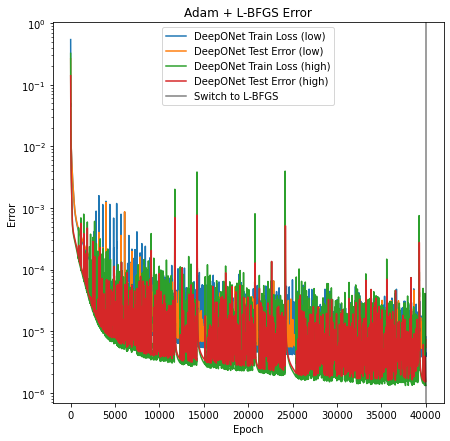

In [341]:
plt.figure(figsize=[7,7])
x = np.linspace(0,epochs,int((epochs)/25))
x_low = np.linspace(0,iter_count_low,int((iter_count_low)/25))+epochs
plt.plot(loss_list_DeepONet_low_adam)
plt.plot(x,test_error_DeepONet_low_adam)

x_high = np.linspace(0,iter_count_high,int((iter_count_high)/25))+epochs
plt.plot(loss_list_DeepONet_high_adam)
plt.plot(x,test_error_DeepONet_high_adam)

plt.axvline(x=epochs,c='black', linestyle='-', alpha=0.5)

plt.title('Adam + L-BFGS Error')
plt.ylabel('Error')
plt.yscale('log')
plt.xlabel('Epoch')
plt.legend(['DeepONet Train Loss (low)','DeepONet Test Error (low)','DeepONet Train Loss (high)','DeepONet Test Error (high)','Switch to L-BFGS'])
plt.show()